In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd

from skimage import io
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb, rgb2gray
from skimage.filters import try_all_threshold, threshold_isodata, threshold_minimum, threshold_otsu, threshold_triangle


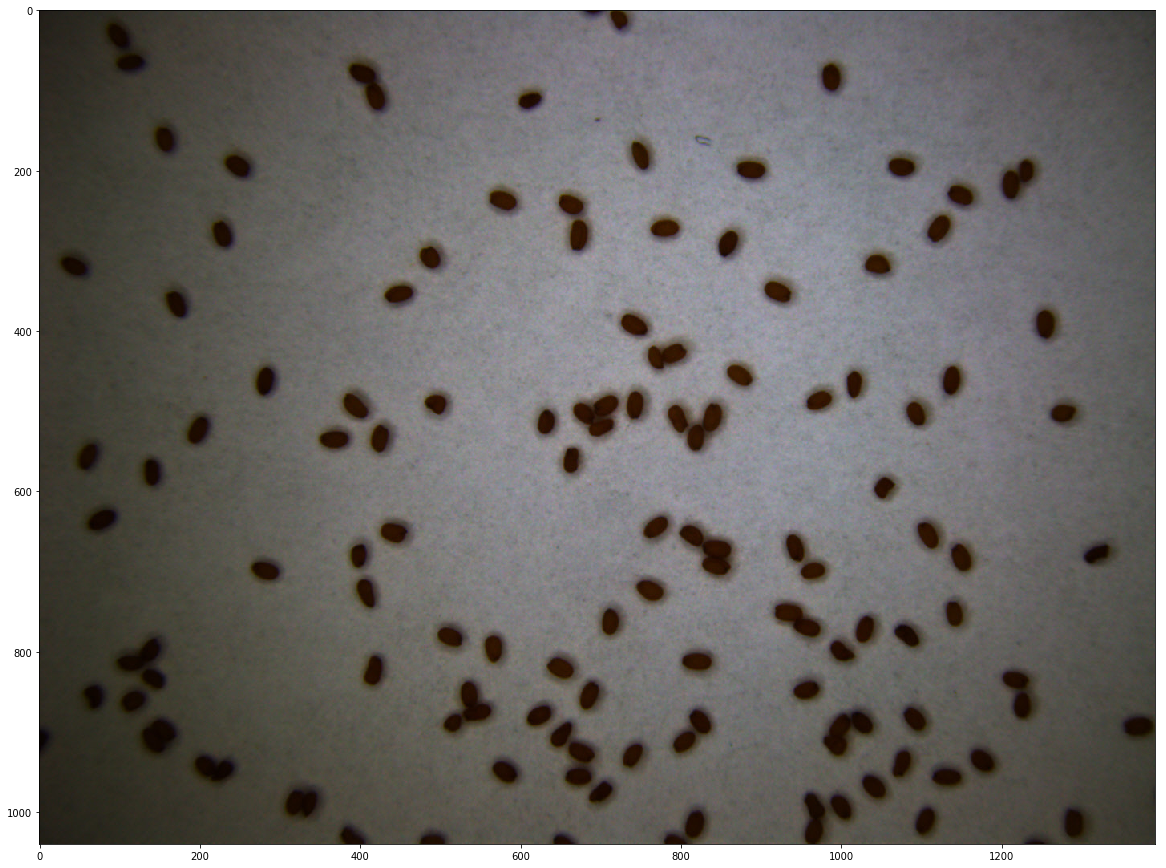

In [38]:
image = io.imread('14251.5_1_BF.jpg')
plt.figure(figsize = (20,20))
plt.imshow(image)

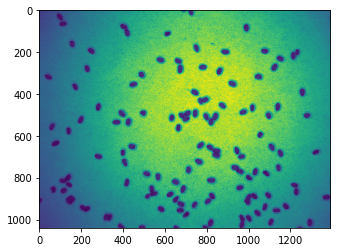

In [40]:
gray_image = rgb2gray(image)
plt.imshow(gray_image)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 576x360 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a3a98c048>,
       dtype=object))

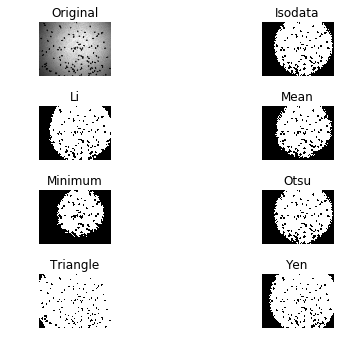

In [43]:
try_all_threshold(gray_image)

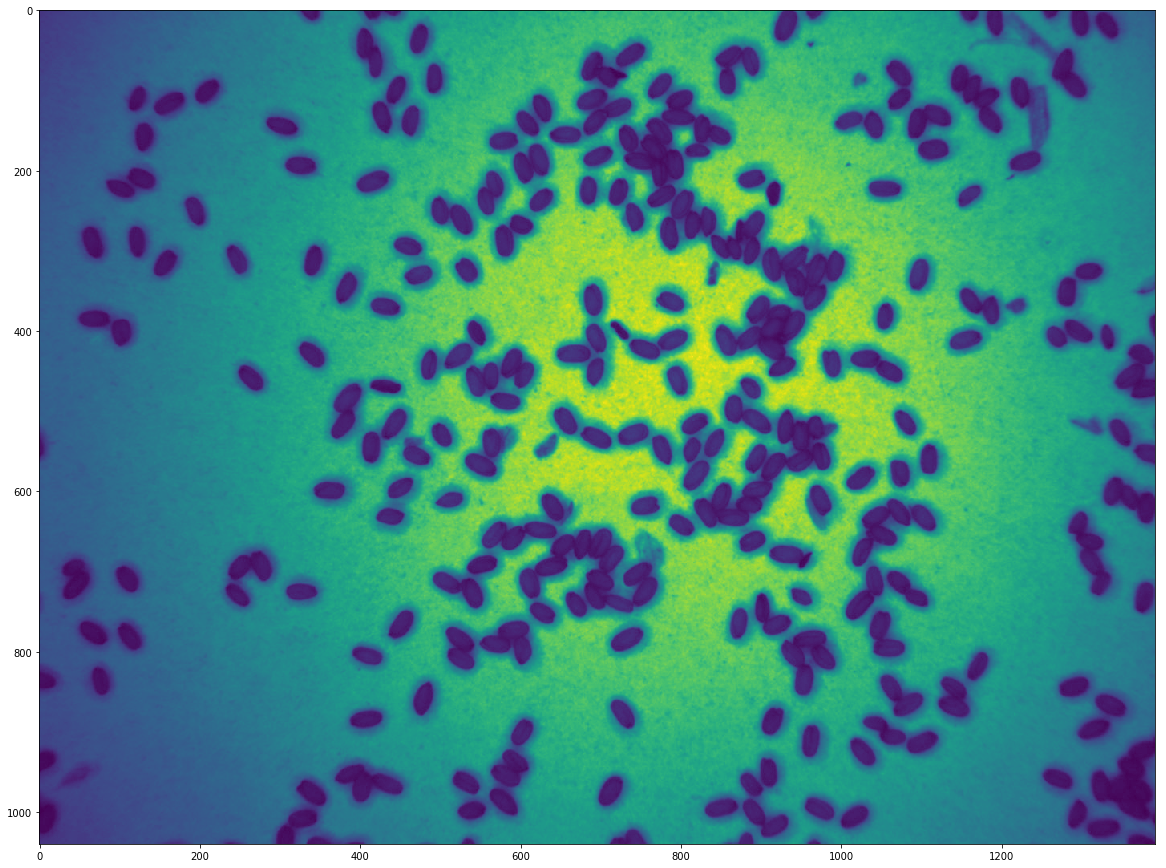

In [67]:
image2 = io.imread('14251.5_3(1)_BF.jpg')
plt.figure(figsize = (20,20))
plt.imshow(image2)
gray_image2 = rgb2gray(image2)
plt.imshow(gray_image2)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 576x360 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a3a07b9e8>,
       dtype=object))

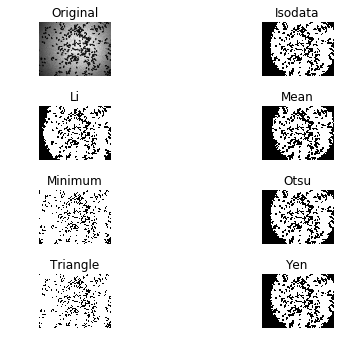

In [68]:
try_all_threshold(gray_image2)

In [69]:
thresh1 = threshold_minimum(gray_image2)
thresh2 = threshold_triangle(gray_image2)
print(thresh1)
print(thresh2)

0.1406969998468137
0.12460388403799019


In [64]:
thresh1 = threshold_minimum(gray_image)
thresh2 = threshold_triangle(gray_image)
print(thresh1 )
print(thresh2)

0.4408135753676471
0.1671961917892157


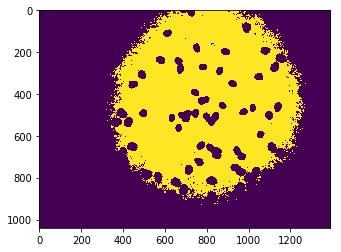

In [42]:
thresh1 = threshold_minimum(gray_image)
thresh2 = threshold_triangle(gray_image)
binary = gray_image > thresh
plt.imshow(binary)

In [25]:
# Label regions
bw = closing(binary, square(3)) 
cleared = clear_border(bw) #ignore all the seeds at the edge of the image
label_image = label(cleared)
seed = 0

for region in regionprops(label_image):
    seed = seed + 1
print(seed)

90


In [27]:
# Label regions
bw = closing(binary, square(3)) 
cleared = clear_border(bw) #ignore all the seeds at the edge of the image
label_image = label(cleared)
seed = 0
cali_seed = 0
cali_area = 0
large_area = 0

for region in regionprops(label_image):
    if 400 < region.area < 800 :
        cali_seed = cali_seed + 1
        cali_area = cali_area + region.area
    if 5 < region.area < 700:
        seed = seed + 1
    elif region.area > 700:
        large_area = large_area + region.area

ave_area = cali_area / cali_seed
large_seed = large_area / ave_area
seed = seed + large_seed
print(ave_area)
print(seed)

491.7317073170732
114.32959674619315


In [73]:
def BFCount (Filename = '14230.2_5(3)_BF.jpg', Test = False, QuickCheck = False):
    # This function count seeds in BF images
    # The default Filename is for testing 
    # 'Test' allows you to check all different threshold methods, normally used for individual images
    # 'QuickCheck' allows you to check the binary images current method ('minimum' in this case), 
    #  normally used for all images
    
    image = io.imread(Filename)
    gray_image = rgb2gray(image)
    
    # Set threshold using the smaller value of 'minimum' and 'triangle' method 
    thresh1 = threshold_minimum(gray_image)
    thresh2 = threshold_triangle(gray_image)
    thresh = min(thresh1,thresh2)
    binary = gray_image < thresh
    
    if Test == True:
        try_all_threshold(gray_image)
        return
    
    if QuickCheck == True:
        plt.figure()
        plt.imshow(binary)
        plt.title(Filename)
        return
    
    # Label regions
    bw = closing(binary, square(3)) 
    cleared = clear_border(bw) #ignore all the seeds at the edge of the image
    label_image = label(cleared)
    seed = 0
    cali_seed = 0
    cali_area = 0
    large_area = 0

    for region in regionprops(label_image):
        if 400 < region.area < 700 :
            cali_seed = cali_seed + 1
            cali_area = cali_area + region.area
        if 5 < region.area < 700:
            seed = seed + 1
        elif region.area > 700:
            large_area = large_area + region.area
    
    if cali_seed == 0:
        print('Calibrition of seed area failed: ' + Filename +' Check image:')
        plt.figure()
        plt.imshow(binary)
        return -1
    else:
        ave_area = cali_area / cali_seed
        large_seed = large_area / ave_area
        seed = seed + large_seed
        return int(seed)

    #print('average area of seeds is: ' + str(ave_area))
    #print('There are ' + str(int(large_seed)) + ' overlapping seeds')
    #print('Total seeds: ' + str(int(seed)))



## All-in-One Funtion

In [74]:
def Give_Me_BFCounts(File = '*_BF.jpg', QuickCheck = False, Test = False):
    # This function takes a group of files as input, calculate the seeds and combine the number per 
    # consrtucts. Output is a .csv file
    # I suggest you first run a quick check of the binary images you create from thresholding methods, to do this,
    # use 'QuickCheck = True'
    
    if QuickCheck == True: 
        for file in glob.glob(File):
            BFCount(file, QuickCheck = True)
        return

    OutBF = []
    for file in glob.glob(File):
        dic = {'File':file, 'Seed':BFCount(file,Test)}
        OutBF.append(dic)

    df = pd.DataFrame(OutBF, columns=OutBF[0].keys())

    FileList = df['File']

    ConsList = []
    for i in FileList:
        ConsList.append(i.split('(')[0])
    ConsList = list(set(ConsList))

    CleanDf = []
    for i in ConsList:
        sub = df[df['File'].str.match(str(i))]
        dic = {'Construct' : str(i), 'Total Seed': sub['Seed'].sum()}
        CleanDf.append(dic)

    Counts = pd.DataFrame(CleanDf, columns=CleanDf[0].keys())
    display(Counts)

    df.to_csv('Counts_BF_Individual.csv')
    Counts.to_csv('Counts_BF.csv')

   

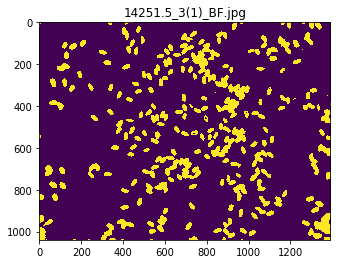

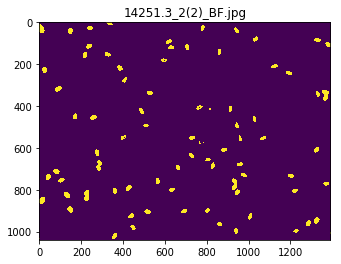

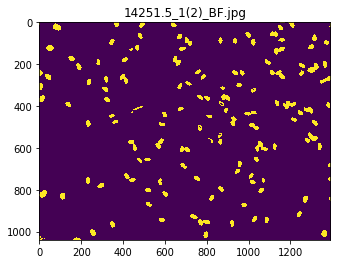

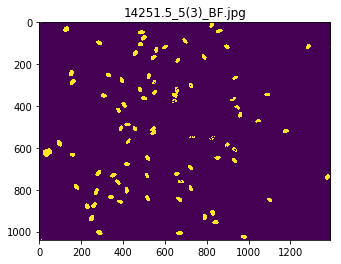

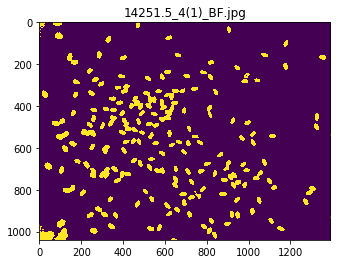

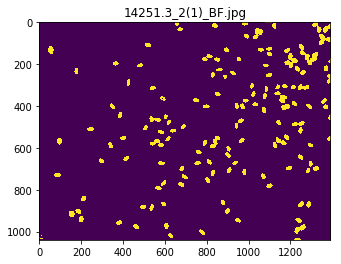

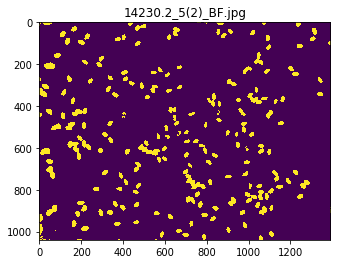

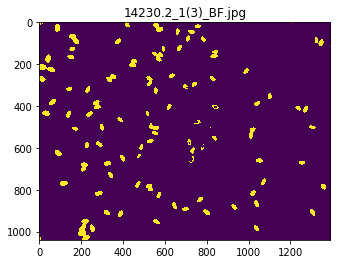

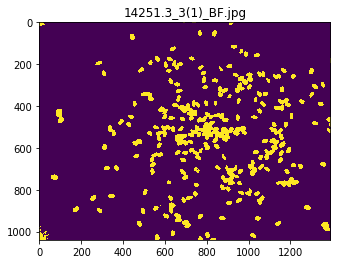

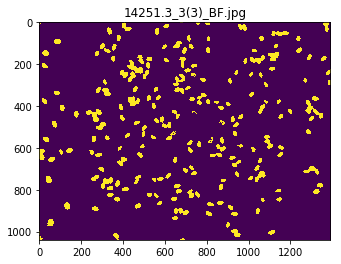

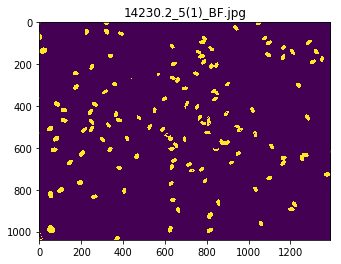

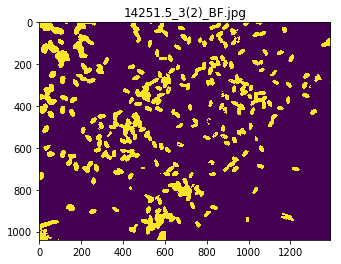

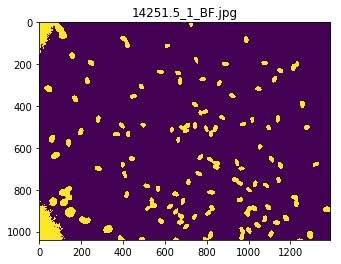

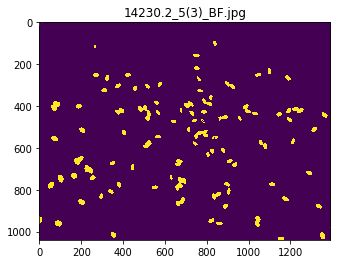

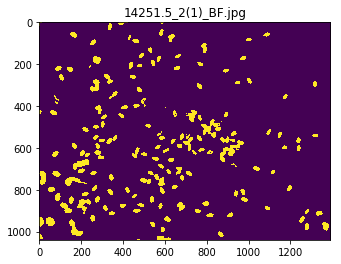

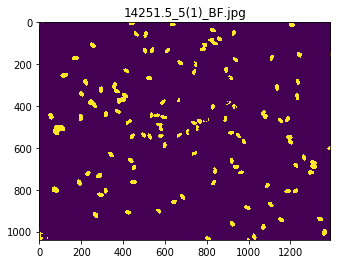

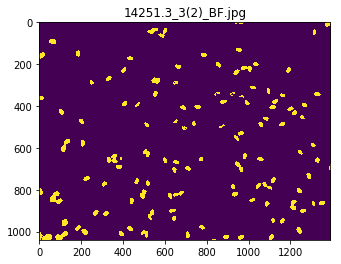

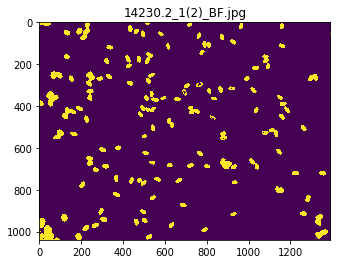

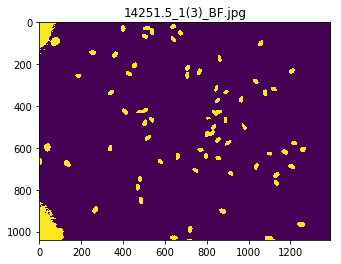

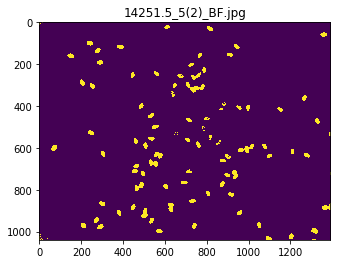

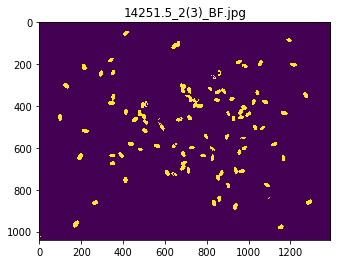

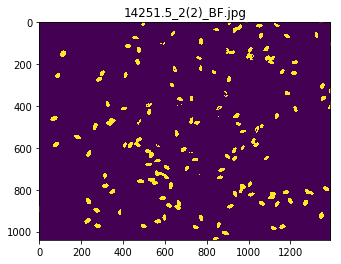

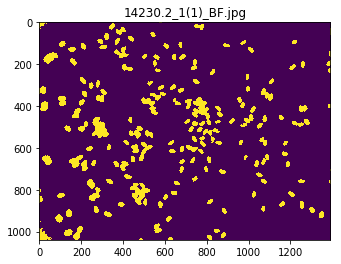

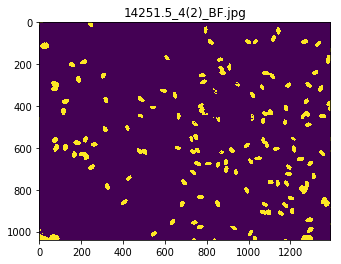

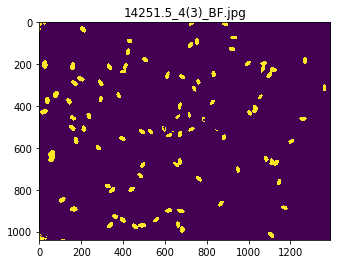

In [75]:
Give_Me_BFCounts(QuickCheck = 1)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


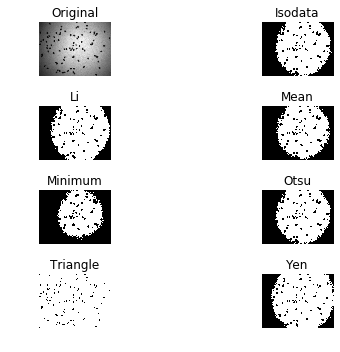

In [58]:
BFCount('14251.5_4(3)_BF.jpg', Test = 1)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


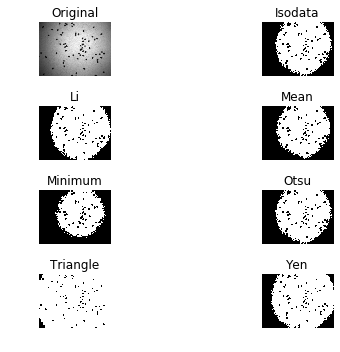

In [59]:
BFCount('14251.5_1(3)_BF.jpg', Test = 1)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


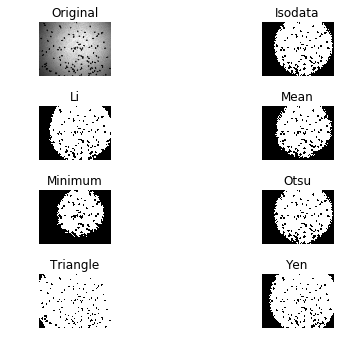

In [60]:
BFCount('14251.5_1_BF.jpg', Test = 1)